# Vehicle Detection

Goal: Write a software pipeline to identify vehicles in a video from a front-facing camera on a car.


In [1]:
import time
import numpy as np
import cv2
import glob
import pickle
import threading
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

# Function to draw image with caption
def plotImg(img, caption, cmap='gray'):
    plt.figure()
    plt.axis('off')
    ht = img.shape[0]+25
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)    
    plt.text(0,ht,caption)

# Load and return image in RGB space
def loadImage(fname):
    return cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

imgNo = 1
figNo = 1
def plotSubImage(img, caption, cmap='gray'):
    global imgNo
    plt.subplot(1, 2, imgNo)
    imgNo += 1
    plt.axis('off')

    scaledShape=(64, int(64.0*img.shape[1] / img.shape[0]))
    if len(img.shape) == 2:
        plt.imshow(img, shape=scaledShape, cmap=cmap)
    else:
        plt.imshow(img, shape=scaledShape)
        
    plt.text(0, 0, caption, fontsize=10)


## Histogram of Oriented Gradients (HOG) Features

All images are read from disk using OpenCV's imread function and converted to RGB color space. This ensures uniformity across training data sets, for PNG and JPEG file formats.

Steps to extract HOG features:
 - Images are converted to YCrCb color space.
 - Hog features are extracted from the Y channel as it contains sharp edges using skimage's hog function

I experimented with HLS, HSV, YCrCb and RGB and selected YCrCb for the following reasons:
- Y channel contains sharp edges, produces better hog features
- Gives fewer false positives than L channel in HLS and S/V channels in HSV
- RGB worked well when HOG features were extracted from all three channels.
- Extracting hog features on only one channel increases frame rate significantly. Therefore I opted to use just the Y channel from YCrCb color space. Dropping Cr, Cb channels did not affect validation error.

I experimented with various values for HOG parameters and got varying results.
Reducing the number of orientation bins reduced recognition accuracy.
Finally, I settled for the optimal parameters mentioned by Dalal and Triggs in their seminal work on face detection. This worked well for car detection as well.
 - Number of Orientations: 9
 - Pixels per cell = 8
 - Cells per block = 2
 
### Color Features
In addition to HOG features, I also use (i) spatial binning of color features by downsampling to 32x32x3 and (ii) 32 bin color histograms of 32x32 image areas.

The three feature arrays are stacked horizonatally to make the raw feature data.

In [2]:
# Convert image color space if other than 'RGB'
def color_conv_image(image, colorspace):
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            cc_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            cc_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            cc_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            cc_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            cc_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        cc_image = np.copy(image)
    return cc_image

# Function to return HOG features and visualization for a single channel
def get_hog_feature_vector(img, orient, pix_per_cell, cell_per_block,visualise=False):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=visualise, feature_vector=True)

# Compute HOG on image with multi-channels
def get_hog_feature_vector_multi_channel(feature_image, orient, pix_per_cell, cell_per_block):
    if len(feature_image.shape) > 2: # all channels
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_feature_vector(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block))
    else:
        hog_features = get_hog_feature_vector(feature_image, orient, pix_per_cell, cell_per_block)

    return np.ravel(hog_features)
    
# Function to compute color histogram features  
def color_hist(rgb_img, nbins=32, bins_range=(0, 256)):
    assert (len(rgb_img.shape)==3),"Input image must have three channels"
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(rgb_img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(rgb_img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(rgb_img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Function to compute color histogram features
def bin_spatial(feature_image, size=(32, 32)):           
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features


In [3]:
### Feature genration parameters
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0  # Can be 0, 1, 2, or "ALL"

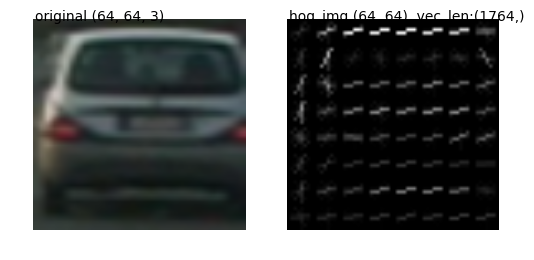

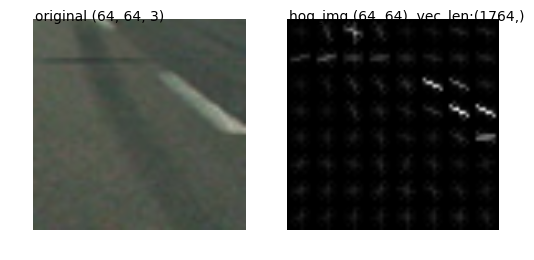

In [4]:
# Compute and diplay hog visualization
def hog_sample(fname):
    global imgNo
    image = loadImage(fname)
    cc_image = color_conv_image(image, colorspace)
    if len(cc_image.shape) > 1:
        cc_image = cc_image[:,:,hog_channel]
    fvec, hog_img = get_hog_feature_vector(cc_image, orient, pix_per_cell, cell_per_block, visualise=True)
    plt.figure()
    imgNo = 1
    plotSubImage(image, 'original {0}'.format(image.shape))
    plotSubImage(hog_img, 'hog_img {0}, vec_len:{1}'.format(hog_img.shape,fvec.shape))

hog_sample('vehicles/GTI_MiddleClose/image0313.png')
hog_sample('non-vehicles/GTI/image2319.png')


## Training

### Normalizing features
Raw feature data is scaled to zero mean and fit to unit variance using sklearn's StandardScaler. The scaler parameters are preserved for later use on un-labeled data.

### Data Set
I used the project data-set of vehicle and non-vehicle data.
* Vehicle data set: 8798 samples
* Non-vehicle data set: 8971 samples

### Process
* Image file names are enumerated from disk using glob.
* Features are extracted for each image using the `extract_features_filelist` function that iterates through each file and collects all the features.
* Car and non-car features are combined into a single training data set X and the labels are assembled in the y array.
* X is scaled using the standard scaler as described above.
* The data is split into training and validation data sets using sklearn's train_test_split function.
* This function also shuffles training and labels.
* I fit a linear SVM model to the data using sklearn's LinearSVC class. The SVM is persisted for later re-use.

Based on validation data, the classifier's accuracy is 98.62%. With additional sample data, I think it could be improved.

In [5]:
# Function to extract features from a list of images
def extract_features_filelist(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = loadImage(file)
        features.append(extract_image_features(img))
    return features

# Function to return a feature vector for a given image
def extract_image_features(image):
    # Convert color
    cc_image = color_conv_image(image, colorspace)

    # Compute HOG features
    hog_features = get_hog_feature_vector_multi_channel(cc_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(cc_image, size=spatial_size)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(cc_image, nbins=hist_bins, bins_range=hist_range)

    # Append the new feature vector to the features list
    return np.concatenate((spatial_features, hist_features, hog_features))


In [6]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Extract features for cars and non-cars
t=time.time()
car_features = extract_features_filelist(cars)
notcar_features = extract_features_filelist(notcars)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# SVM for classification
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save model and scaler to disk
with open('model.p', 'wb') as f:
    pickle.dump((svc,X_scaler), f)

24.42 Seconds to extract features...
Feature vector length: 4932
8.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9831
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.00077 Seconds to predict 10 labels with SVC


In [7]:
# load model
with open('model.p', 'rb') as f:
    (svc2, X_scaler2) = pickle.load(f)


## Sliding Windows

Since the region of interest is only the bottom half of the image (where the road is), input images are cropped early on to save on computation time. All further computations work with the assumption that the image is the rego already cropped.

I defined three window groups according to scale: 64x64 (1xscale), 96x96 (1.5x scale) and 128x128 (2x scale).
The `WindowZoneDefinition` structure defines how each window group is laid out on the image. Actual window coordinates are calculated to fit 64x64 on a scaled image.
Each group is defined by:
- a bounding box defined by y0 (top), y1 (bottom), x0 (left), x1 (right) as fractions of image width and height.
- overlap factor: how much adjacent windows overlap.
- points: allows differential weighting for each group.
- scale: image scaling factor.
- unique color to help analyze contributions from each group.

Windows are laid out in a rectangular pattern, with the edges tapered to avoid covering areas that are generally outside the road.

This method creates 374 search windows in all.

Number of windows: 547


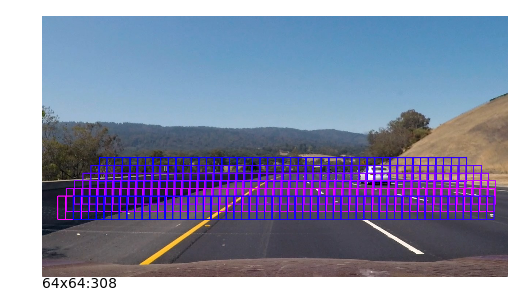

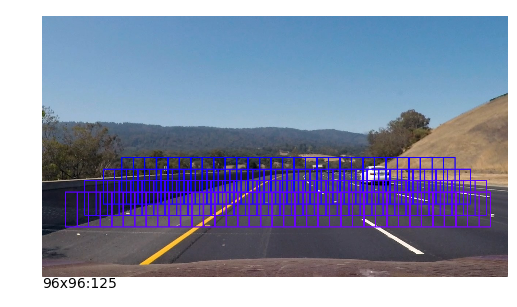

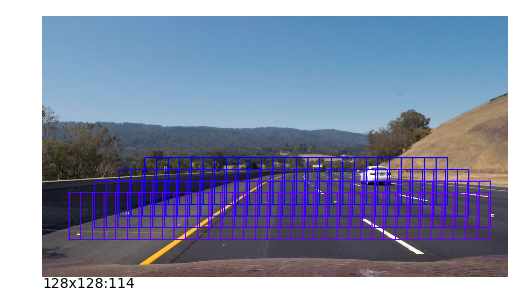

In [8]:
# Window scales
WindowZoneDefinitions = [
    {'name': '64x64', 'scale': 1., 'y0': 0., 'y1': 0.5, 'x0': 0., 'x1': 1., 'overlap_factor': 3, 'points': 1, 'color':(255,0,0)},
    {'name': '96x96', 'scale': 1.5, 'y0': 0, 'y1': 0.5, 'x0': 0., 'x1': 1., 'overlap_factor': 3, 'points': 1, 'color':(0,255,0)},
    {'name': '128x128', 'scale': 2., 'y0': 0, 'y1': 0.5, 'x0': 0., 'x1': 1., 'overlap_factor': 4, 'points': 1, 'color':(0,0,255)},
    ]

# Function compute coordinates for windows given an image shape
# Assumes image is cropped to region of interest
def make_windows(shape):
    # define viewport within image
    ht = shape[0] - 128
    wd = shape[1]
    top_offset = 32
    left_offset= 32
    
    # Scan zone coordinates
    windowSizes = []
    for winDef in WindowZoneDefinitions:
        windowSizes.append(
            ( 
                int( (top_offset + ht*winDef['y0'])/winDef['scale'] ),
                int( (top_offset + ht*winDef['y1'])/winDef['scale'] ),
                int( left_offset/winDef['scale'] ),
                int( ((wd-left_offset) * winDef['x1'])/winDef['scale'] ),
                winDef['overlap_factor']
            )
            )

    # Layout windows
    windows=[]
    dim = 64
    for (idx,(scan_y0,scan_y1,scan_x0,scan_x1,factor)) in enumerate(windowSizes):
        windows.append([])
        y0 = scan_y0
        while y0 < scan_y1:
            gap = int( (shape[1] // 8) - y0 * ((shape[1] // 8) / scan_y1))
            for x0 in range(scan_x0 + gap, scan_x1 - gap, dim//factor):
                window = np.array( ((x0, y0), (x0+dim, y0+dim)) )
                if(window[0][0] >= 0 and window[0][1] >= 0 and window[1][0] < scan_x1 and window[1][1] < scan_y1+dim):
                    windows[idx].append(window)
            y0 += dim // factor
    return windows

# Load test image,
img = loadImage("test_images/test3.jpg")
# Crop to region of interest
half = img.shape[0]//2
bottom_half_img = img[half:,:,:]
# compute windows
windows = make_windows(bottom_half_img.shape)

def plotWindows(img, windowset, scale, half, setname):
    img = np.copy(img)
    for idx,w in enumerate(windowset):
        cv2.rectangle(img, (int(w[0][0]*scale),int(w[0][1]*scale+half)), (int(w[1][0]*scale),int(w[1][1]*scale+half)), ((idx%255),0,255), 2)
    plotImg(img, "{0}:{1}".format(setname, len(windowset)))
    return len(windowset)

# Draw overlays
total = 0
for idx,wgrp in enumerate(windows):
    total += plotWindows(img, wgrp, WindowZoneDefinitions[idx]['scale'], half, WindowZoneDefinitions[idx]['name'] )

print("Number of windows: %d" % total)

## Car detection

I tested the windows on test images that were provided along with the project. In each case, cars are detected by windows in multiple scale groups. But there are also several false positives due to the fact the classifier accuracy was only 98%.

The below code does not optimize CPU - it only serves to show how effective the window groups are.

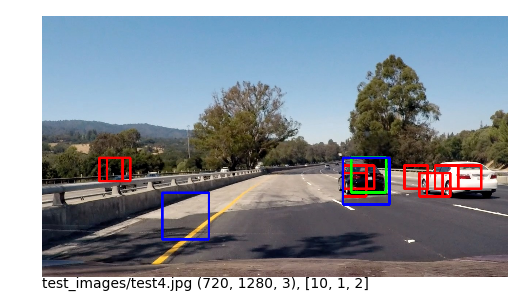

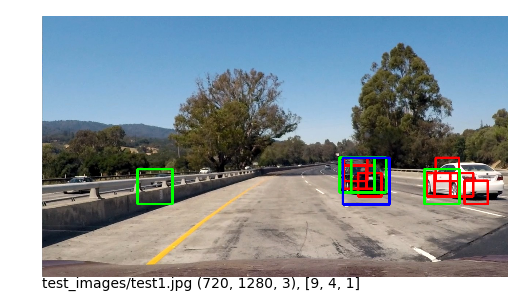

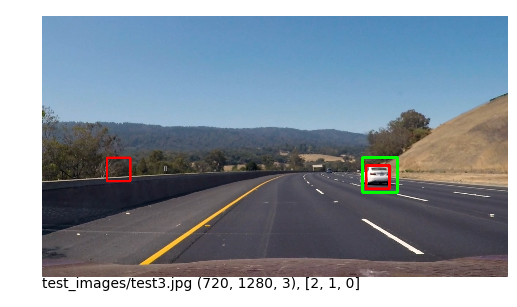

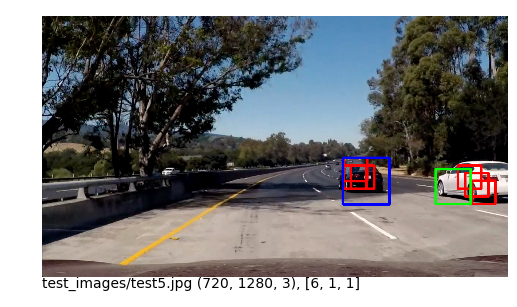

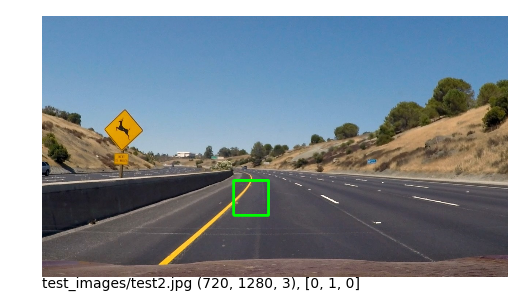

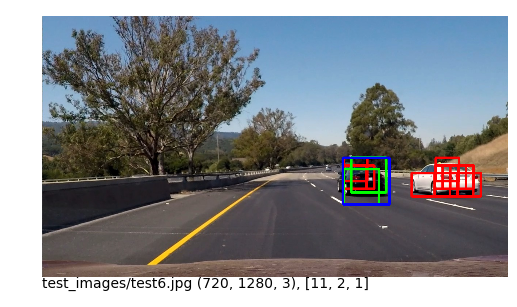

In [9]:
# Returns features for each window on an image
# computes hog for each window - inefficient
def image_features(img, windows):
    features = []
    winrefs = []

    for idx,winGrp in enumerate(windows):
        scale = WindowZoneDefinitions[idx]['scale']
        for winIdx,window in enumerate(winGrp):
            test = img[int(window[0][1]*scale):int(window[1][1]*scale), int(window[0][0]*scale):int(window[1][0]*scale)]
            winrefs.append((idx, winIdx))
            test64 = cv2.resize(test, (64,64))
            features.append(extract_image_features(test64))
    return features, winrefs

# Augment image with windows that test positive for CAR 
def imgPipeline(img):
    half = img.shape[0]//2
    bottom_half_img = img[half:,:,:]
    windows = make_windows(bottom_half_img.shape)
    features,winrefs = image_features(bottom_half_img, windows)
    scaled_features = X_scaler2.transform(features)
    pred = svc2.predict(scaled_features)

    matchesPerGroup=[0]*len(WindowZoneDefinitions)
    for idx in np.argwhere(pred == 1):
        wref = winrefs[idx]
        w = windows[wref[0]][wref[1]]
        matchesPerGroup[wref[0]] += 1
        scale = WindowZoneDefinitions[wref[0]]['scale']
        cv2.rectangle(img, ( int(w[0][0]*scale), int(w[0][1]*scale+half) ), 
                      ( int(w[1][0]*scale), int(w[1][1]*scale+half) ), WindowZoneDefinitions[wref[0]]['color'], 6)
        
    return img, matchesPerGroup

# Iterate through test images
for fname in glob.glob('test_images/*.jpg'):
    img = loadImage(fname)
    img, matchesPerGroup = imgPipeline(img)
    plotImg(img, "{0} {1}, {2}".format(fname, img.shape, matchesPerGroup))

## Pipeline

The `detectCars` function below implements a basic pipeline to get windows that have cars (or parts of cars) in them.

### Processing Optimization
- Image is cropped to region of interest (bottom half)
- Each window group is processed in a separate thread so that each group can be processed concurrently, maximizing CPU usage.
- Each thread scales the image down to match its assigned window scale.
- Then HOG features are pre-computed on the entire image.
- For each window, HOG feature values are looked-up instead of computed. This avoids having to compute HOG for overlapping window regions and makes processing much faster.


### Heat maps
- After the threads have completed, we have a collection of windows that have cars in them. These windows combined into a heatmap as shown below.
- I experimented with several ways of merging windows into heat maps before settling for the simpler addition method.
 - Simple addition: +1 for areas within windows 
 - Weighting windows with larger scale: 1.5x: 2pts, 2x: 3pts
 - Enhancing areas where more than one window group overlaps
  - start with a matrix of 1's and multiply areas within windows with 2

- Heatmaps vary based on SVM results, I found that averaging them over several frames gives a stable bounding box over the cars.

- Finally, heatmaps are thresholded with a number determined through trial and error. This step eliminates stray false positives.

### Car bounding boxes
- Heat maps are labeled using scipy's label function. This assigns a unique value to each connected region of the heatmap - which should correspond to a car.
- The corners of each label is the bounding box for the car.



Number of windows: 547
2 cars found in 0.513 s


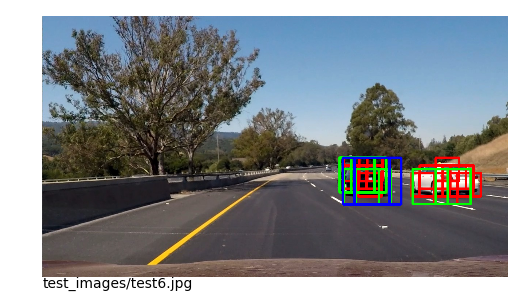

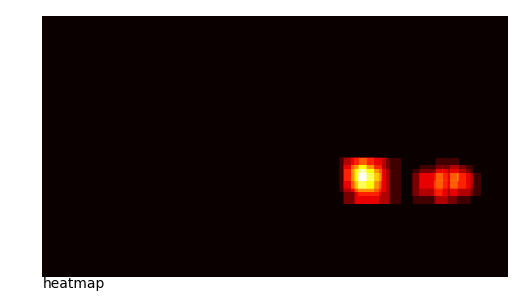

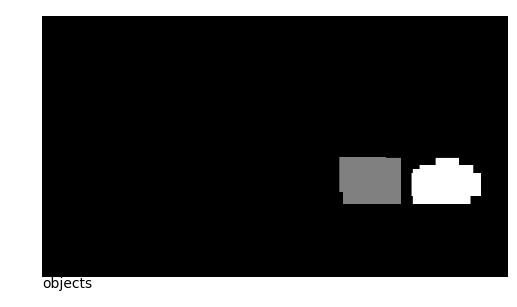

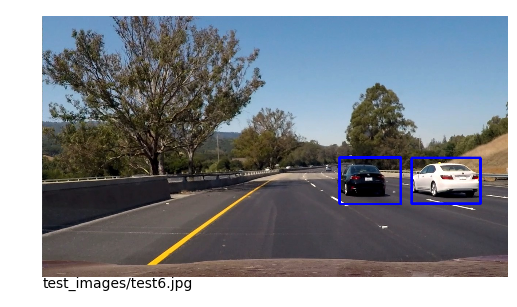

In [10]:
# Thread subclass to execute car-search for windows of a given scale
class CarDetectionThread(threading.Thread):
    # constructor - save references
    def __init__(self, scaleGroup, scale, cc_img, windows, detectedWindows):
        threading.Thread.__init__(self)
        self.scaleGroup = scaleGroup
        self.scale = scale
        self.cc_img = cc_img
        self.windows = windows
        self.detectedWindows = detectedWindows

    def run(self):
        
        #start_time = time.time()
        # scale image to 'my assigned window scale'
        scaled_cc_img = cv2.resize(self.cc_img, (int(self.cc_img.shape[1] / self.scale), 
                                                 int(self.cc_img.shape[0] / self.scale) ))

        # Pre-compute hog for entire image - on only one channel
        hog_maps = [
            hog(scaled_cc_img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
            #,hog(scaled_cc_img[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
            #,hog(scaled_cc_img[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        ]
        #hog_end_time = time.time()

        # Scale factor going from original image space to scaled space
        pxToHog = scaled_cc_img.shape[0] // hog_maps[0].shape[0]

        # Collect features for each window
        features = []
        for w in self.windows:
            
            # Get area of original image for a window
            blob = scaled_cc_img[w[0][1]:w[1][1], w[0][0]: w[1][0],  : ]
            # scale window to hog cache scale
            h = w // pxToHog
            h[1][0] -= 1
            h[1][1] -= 1

            # look up hog features
            hog_features = []
            hog_features.append( hog_maps[0][ h[0][1]:h[1][1], h[0][0]: h[1][0] ] )
            #hog_features.append( hog_maps[1][ h[0][1]:h[1][1], h[0][0]: h[1][0] ] )
            #hog_features.append( hog_maps[2][ h[0][1]:h[1][1], h[0][0]: h[1][0] ] )
            hog_features = np.ravel(hog_features)

            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(blob, size=spatial_size)

            # Apply color_hist() also with a color space option now
            hist_features = color_hist(blob, nbins=hist_bins, bins_range=hist_range)

            features.append( np.concatenate((spatial_features, hist_features, hog_features)) )
            
        #feature_prep = time.time()

        # run scaler and classifier
        scaled_features = X_scaler2.transform(features)
        pred = svc2.predict(scaled_features)
        
        # Append windows with cars predicted in them.
        #predict_time = time.time()
        for idx in np.argwhere(pred == 1):
            w = self.windows[idx]
            w = (w * self.scale).astype(np.int32)
            w[0][1] += self.cc_img.shape[0]
            w[1][1] += self.cc_img.shape[0]
            self.detectedWindows[self.scaleGroup].append(w)

        #print("Hog: {0}, Feature: {1}, Predict: {2}".format(hog_end_time-start_time, feature_prep-hog_end_time, predict_time-feature_prep))

# Drive car detection process
def detectCars(original_image):
    global windows
    
    # Chop input image to region of interest
    input_image = original_image[original_image.shape[0]//2:,:,:]
    
    # Pre-compute window coordinates and reuse them - these don't change across frames
    if windows == None:
        windows = make_windows(input_image.shape)
        total = 0
        for wgrp in windows:
            total += len(wgrp)
        print("Number of windows: %d" % total)
    
    # convert color space
    cc_img = color_conv_image(input_image, colorspace)
    
    # Collection for receiving results from the threads
    detectedWindows = []
    for winDef in WindowZoneDefinitions:
        detectedWindows.append([])

    # Fire up threads to execute car search
    threads = []
    for scaleGroupIdx, winDef in enumerate(WindowZoneDefinitions):
        thread = CarDetectionThread(scaleGroupIdx, winDef['scale'], cc_img, windows[scaleGroupIdx], detectedWindows)
        threads.append(thread)
        thread.start()
    # wait for threads to finish
    for thread in threads:
        thread.join()

    return detectedWindows

# Generate heatmap from detections: multiply overlapping zones 
def filteredHeatMap(img, detections, filter=0):
    heatmap = np.ones((img.shape[0], img.shape[1]))
    for grpidx, grp in enumerate(detections):
        for w in grp:
            heatmap[w[0][1]:w[1][1], w[0][0]:w[1][0]] *= WindowZoneDefinitions[grpidx]['points']
    heatmap[heatmap <= filter] = 0
    return heatmap

# Generate heatmap from detections: Look for multiple scale windows to overlap
def filteredHeatMap(img, detections):
    global heatmap_cache
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.int32)
    for grpidx, grp in enumerate(detections):
        heatmap_grp = np.zeros((img.shape[0], img.shape[1]), dtype=np.int32)
        for w in grp:
            heatmap_grp[w[0][1]:w[1][1], w[0][0]:w[1][0]] = WindowZoneDefinitions[grpidx]['points']
        heatmap += heatmap_grp
    heatmap[heatmap <= 1] = 0

    if heatmap_cache == None:
        heatmap_cache = heatmap
    else:
        heatmap_cache[heatmap_cache > 3] = 3
        for n in range(2):
            heatmap_cache[heatmap_cache > 0] -= 1
        heatmap_cache += heatmap
    return heatmap_cache

# Heat map cache for cross-frame averaging
heatmap_cache = None
def initHeatMapCache():
    global heatmap_cache
    heatmap_cache = [None] * 5

# Generate averaged heat map
def averagedHeatMap(img, detections, filter = 0):
    global heatmap_cache
    
    # Compute current heatmap
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.int32)
    for grpidx, grp in enumerate(detections):
        for w in grp:
            heatmap[w[0][1]:w[1][1], w[0][0]:w[1][0]] += WindowZoneDefinitions[grpidx]['points']
    
    # Average over past heatmaps
    heatmap_cache.append(heatmap)
    heatmap_cache.pop(0)
    heatmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.int32)
    for hm in heatmap_cache:
        if hm != None:
            heatmap += hm
    heatmap[heatmap < filter] = 0

    return heatmap

# Test pipeline on single image
windows = None
fname = 'test_images/test6.jpg'
initHeatMapCache()
img = loadImage(fname)
img2 = np.copy(img)
start_ts = time.time()
detections = detectCars(img)
heatmap = averagedHeatMap(img, detections)
labels = label(heatmap)
end_ts = time.time()
print(labels[1], 'cars found in %.3f s'%(end_ts-start_ts))

for grpidx, grp in enumerate(detections):
    color = WindowZoneDefinitions[grpidx]['color']
    for w in grp:
        cv2.rectangle(img2, (w[0][0], w[0][1]), (w[1][0], w[1][1]), color, 6)
plotImg(img2, fname)
plotImg(heatmap,"heatmap", cmap='hot')
plotImg(labels[0], 'objects', cmap='gray')

for car_number in range(1, labels[1]+1):
    # Find pixels with each car_number label value
    nonzero = (labels[0] == car_number).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
plotImg(img, fname)

## Testing

I implemented a test video pipeline to:
- To evaluate all the above steps on a video pipeline
- Determine appropriate thresholds
- Optimize number of windows in each scale group

This augments the video with:
- windows with positive car detections from SVM
- bounding boxes computed after processing heatmap, labeling and thresholding
- displaying maximum heat value in each label so we can determine an ideal threshold that separates the cars from the noise.


In [11]:
# Initialize
initHeatMapCache()

# Frame filter to process only a subset of video - useful when doing trial and error
frameCounter = 0
startFrame = 0
endFrame = 100000

# Function to return list of bounding boxes given a heatmap
def bounding_box_list(heatmap):
    # Label connected areas
    labels = label(heatmap)
    bblist = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bblist.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    return bblist

# Augment image with detections, heatmap info and car bounding boxes
def processImage(img):
    global frameCounter
    frameCounter += 1
    if(frameCounter >= startFrame and frameCounter <= endFrame):

        # Windows with cars
        detections = detectCars(img)

        # Draw windows
        for grpidx, grp in enumerate(detections):
            scale = WindowZoneDefinitions[grpidx]['scale']
            color = WindowZoneDefinitions[grpidx]['color']
            for w in grp:
                cv2.rectangle(img, (w[0][0], w[0][1]),(w[1][0], w[1][1]), color, 2)
        
        # Heatmap, threshold and label
        heatmap = averagedHeatMap(img, detections, 10)
        
        # Bounding boxes
        boxes = bounding_box_list(heatmap)
        for bbox in boxes:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,0), 6)
            
            if bbox[1][1] > bbox[0][1] and bbox[1][0] > bbox[0][0]:
                max_heat = np.max( heatmap[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]] )
                cv2.putText(img, "maxheat:%d" % max_heat, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (250,200,100), 2)
    return img

In [12]:
clip1 = VideoFileClip("project_video.mp4")
modifiedClip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time modifiedClip.write_videofile('project_video.out.mp4', audio=False)

[MoviePy] >>>> Building video project_video.out.mp4
[MoviePy] Writing video project_video.out.mp4


100%|█████████▉| 1260/1261 [10:46<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.out.mp4 

CPU times: user 36min 34s, sys: 26min 42s, total: 1h 3min 16s
Wall time: 10min 46s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video.out.mp4'))

## Final video pipeline

The last step in the video pipepline examines bounding boxes detected in the current frame and looks for overlaps with boxes detected in 7 previous frames. Only boxes that have overlaps in all 7 frames are kept. This ensures continuous, stable tracking of the car.


In [14]:
# Returns True if two boxes intersect
def boxes_intersect(bb1, bb2):
    x1,y1 = bb1[0]
    x2,y2 = bb1[1]
    xp1,yp1 = bb2[0]
    xp2,yp2 = bb2[1]
    return ((x1 <= xp2 and y1 <= yp2 and x2 >= xp1 and y2 >= yp1) or 
            (xp1 <= x2 and yp1 <= y2 and xp2 >= x1 and yp2 >= y1))

# Scans a collection of boxes for intersects
def findOverlappingBoundingBox(bb1, boxlist):
    result = []
    for bb2 in boxlist:
        if boxes_intersect(bb1, bb2):
            result.append(bb2)
    return result

# Compute an 'Average' of two boxes
def averageBoxes(box1, box2):
    w1 = box1[1][0]-box1[0][0]
    w2 = box2[1][0]-box2[0][0]
    h1 = box1[1][1]-box1[0][1]
    h2 = box2[1][1]-box2[0][1]
    width = (w1 + w2) // 2
    height = (h1 + h2) // 2
    cx1, cy1 = (box1[1][0] + box1[0][0]) // 2, (box1[1][1] + box1[0][1]) // 2
    cx2, cy2 = (box2[1][0] + box2[0][0]) // 2, (box2[1][1] + box2[0][1]) // 2
    avg_x, avg_y = (cx1+cx2)//2, (cy1+cy2)//2
    avg_box = (avg_x - (width // 2), avg_y - (height // 2)), (avg_x + (width // 2), avg_y + (height // 2))
    return avg_box


In [15]:
# Initialize
initHeatMapCache()
NumFrames = 7 # number of frames to average bounding boxes over
prevBoundingBoxes = [None] * NumFrames
windows = None

# Frame filter to process only a subset of video - useful when doing trial and error
frameCounter = 0
startFrame = 0
endFrame = 100000

def processImageAvg(img):
    global prevBoundingBoxes, frameCounter
    
    frameCounter += 1
    if(frameCounter >= startFrame and frameCounter <= endFrame):
        
        # Windows with cars
        detections = detectCars(img)
        
        # Heatmap, threshold and label
        heatmap = averagedHeatMap(img, detections, 10)
        
        # Get bounding boxes for cars
        bblist = bounding_box_list(heatmap)
        
        # Look for overlap in previous frames
        for bbox in bblist:
            adj_bbox = bbox
            numFound = 0
            for f in range(NumFrames):
                if prevBoundingBoxes[f] != None:
                    prevBBs = findOverlappingBoundingBox(bbox, prevBoundingBoxes[f])
                    matched = False
                    for prevBB in prevBBs:
                        # calc movement
                        # grow box
                        adj_bbox = averageBoxes(adj_bbox, prevBB)
                        matched = True
                    if matched:
                        numFound += 1

            # Found sufficient overlaps, draw the box on the image
            if numFound >= NumFrames:
                cv2.rectangle(img, adj_bbox[0], adj_bbox[1], (255,0,0), 6)
            #else:
                #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

        # Update cache with latest frame
        prevBoundingBoxes.append(bblist)
        prevBoundingBoxes.pop(0)
    return img

In [16]:
clip1 = VideoFileClip("project_video.mp4")
modifiedClip = clip1.fl_image(processImageAvg) #NOTE: this function expects color images!!
%time modifiedClip.write_videofile('project_video.averaged2.mp4', audio=False)

Number of windows: 547
[MoviePy] >>>> Building video project_video.averaged2.mp4
[MoviePy] Writing video project_video.averaged2.mp4


100%|█████████▉| 1260/1261 [10:42<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.averaged2.mp4 

CPU times: user 36min 31s, sys: 26min 31s, total: 1h 3min 2s
Wall time: 10min 43s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video.averaged2.mp4'))

## Discussion

### Improvements
This processing pipeline can be improved in several ways:
- Better classifier
 - Considering deep neural network instead of SVM and leverage GPU
 - Train on a larger set of vehicles
- Intelligent search
 - Instead of brute-force scanning for cars, run a NN or SVM on down-sampled regions to detect 'empty road' and exclude those regions from the search.
 - Detect lane lines and remove them from the image (setting to 0) before searching for cars - this could avoid many false positives.

### Problems
- This implementation relies too heavily on hand-picked thresholds that would not work in other scenarios.
- Weather conditions like snow may introduce more false positives or drop in classification accuracy.
- Vehicles that are too close may fail to classified accurately - especially trucks that have large flat surfaces, so fewer HOG features.
